In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import jax
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as qnp

from scipy.integrate import trapezoid
import time
import pickle
import warnings
warnings.filterwarnings("ignore")

jax.config.update("jax_enable_x64", True)

### Generating Bars and Stripes dataset

In [2]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)

    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))

n = 2
size = n**2
data = get_bars_and_stripes(n)
# print(data.shape)



Sample bitstring: 1010


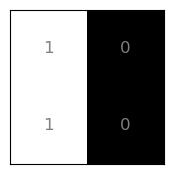

In [3]:
import matplotlib.pyplot as plt

sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")

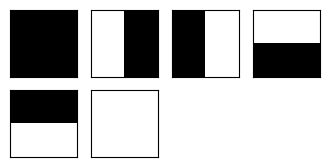

In [4]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

In [5]:
bitstrings = []
nums = []
for d in data:
    bitstrings += ["".join(str(int(i)) for i in d)]
    nums += [int(bitstrings[-1], 2)]
print(nums)

[0, 10, 5, 12, 3, 15]


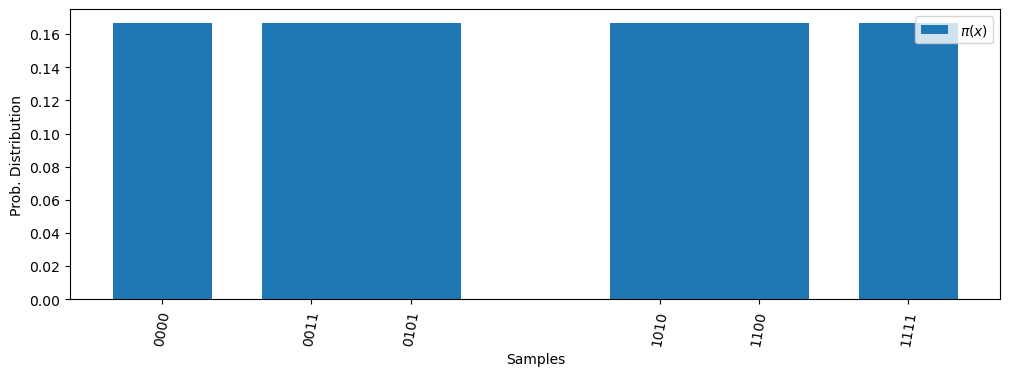

In [6]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$")
plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

In [ ]:
# py_psi = np.zeros(2**size,dtype=complex)
# amp = 1 / math.sqrt(len(data))
# for i in nums:
#     py_psi[i] = amp

# target_dm = np.outer(py_psi,py_psi.conj())

### Trial

In [2]:
target_psi = np.zeros(2**4)
bitstrings_target = ['0000','0011','0101','1010','1100','1111']
nums_target = []
for i in bitstrings_target:
    nums_target += [int(i, 2)]
print(nums_target)

[0, 3, 5, 10, 12, 15]


In [3]:
target_amps = 1/math.sqrt(len(nums_target))
for i in nums_target:
    target_psi[i] = target_amps

In [4]:
target_dm = np.outer(target_psi,target_psi.conj())

In [5]:
bitstrings = ['0000000','0011001','0101010','1010011','1100100','1111101']
nums = []
for i in bitstrings:
    nums += [int(i, 2)]
print(nums)

[0, 25, 42, 83, 100, 125]


In [6]:
psi = np.zeros(2**7)
amps = 1 / math.sqrt(len(bitstrings))
for i in nums:
    psi[i] = amps
dm = np.outer(psi,psi.conj())

In [7]:
reduced_dm = qml.math.reduce_statevector(target_psi,indices=[0,1,2,3])
# reduced_dm = qml.math.reduce_dm(dm,indices=[0,1,2,3])

In [8]:
pxy = reduced_dm - target_dm
dagger_pxy = qml.math.conj(qml.math.transpose(pxy)) # Compute Hermitian conjugate
loss = 0.5 * qml.math.trace(qml.math.sqrt_matrix(dagger_pxy * pxy))
loss


0j

### Functions

In [9]:
from pennylane.math import reduce_statevector
from pennylane import math as qmlmath

n_qubits = 4
n_ancillas = 4
total_qubits = n_qubits + n_ancillas

class TraceDistanceLoss:
    """
    Loss class to compute the trace distance between two probability distributions.
    
    The loss is defined as:
    
        loss(px, py) = 0.5 * trace(sqrt((px - py)† * (px - py)))
    
    Note: The square root here is applied element-wise.
    """

    def __init__(self):
        # You can initialize parameters here if needed.
        pass

    def tr_distance(self, pxy):
        """
        Compute the trace distance of the difference matrix pxy.
        
        Parameters:
            pxy (numpy.ndarray): Difference of two probability distributions.
        
        Returns:
            float: 0.5 * trace of the element-wise square root of (pxy† * pxy).
        """
        dagger_pxy = qmlmath.conj(qmlmath.transpose(pxy)) # Compute Hermitian conjugate
        return 0.5 * qmlmath.trace(qmlmath.sqrt_matrix(dagger_pxy * pxy))
        # return qnp.linalg.norm(pxy)  # temporary fix

    def __call__(self, px, py):
        """
        Compute the loss given two probability distributions px and py.
        
        Parameters:
            px, py (numpy.ndarray): Input probability distributions.
        
        Returns:
            float: Computed loss.
        """
        pxy = px - py
        return self.tr_distance(pxy)
    
class QCBM:

    def __init__(self,circ,trdistance,py):
        self.circ = circ
        self.trdistance = trdistance
        self.py = py

    def qcbm_loss(self,params):
        full_psi = self.circ(params)
        px = reduce_statevector(full_psi,indices=range(n_qubits))
        loss = self.trdistance(px,self.py)
        # print("Statevector is",full_psi)
        return qnp.real(loss)

In [24]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        # qml.RX(ising_params1[i],wires=i)
        # qml.RY(ising_params2[i],wires=i)
        qml.RX(rz_params[i],wires=i)
        # qml.RY(ising_params1[i],wires=i)
        # qml.RZ(ising_params2[i],wires=i)

    # for i in range(total_qubits-1):
    #     qml.CNOT(wires=[i,i+1])
    # qml.CNOT(wires=[total_qubits-1,0])

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[i,i+1])
    qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,0])


    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[i,i+1])
    qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,diff_method="backprop",interface="autograd")
def circuit(input_params,folds=folds,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):
    
    # params = input_params.reshape((folds,3*total_qubits))
    # params = qnp.array(params,requires_grad=True)
    params = qnp.array(input_params, requires_grad=True)
    
    for i in range(total_qubits):
        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=params[i],total_qubits=total_qubits)
    
    # output1 = qml.density_matrix(wires = [i for i in range(num_qubits)])
    output1 = qml.state()
    # output2 = qml.density_matrix([(num_qubits+i) for i in range(n_ancillas)])
    return output1


### Training the Model

In [25]:
key = jax.random.PRNGKey(1)
initial_params = qnp.random.uniform(low=0.0, high=1.0, size=(folds, 3 * total_qubits), requires_grad=True)

#initial_params = jax.random.uniform(key, shape=(folds, (3 * total_qubits)), minval=0.0, maxval=2*math.pi)

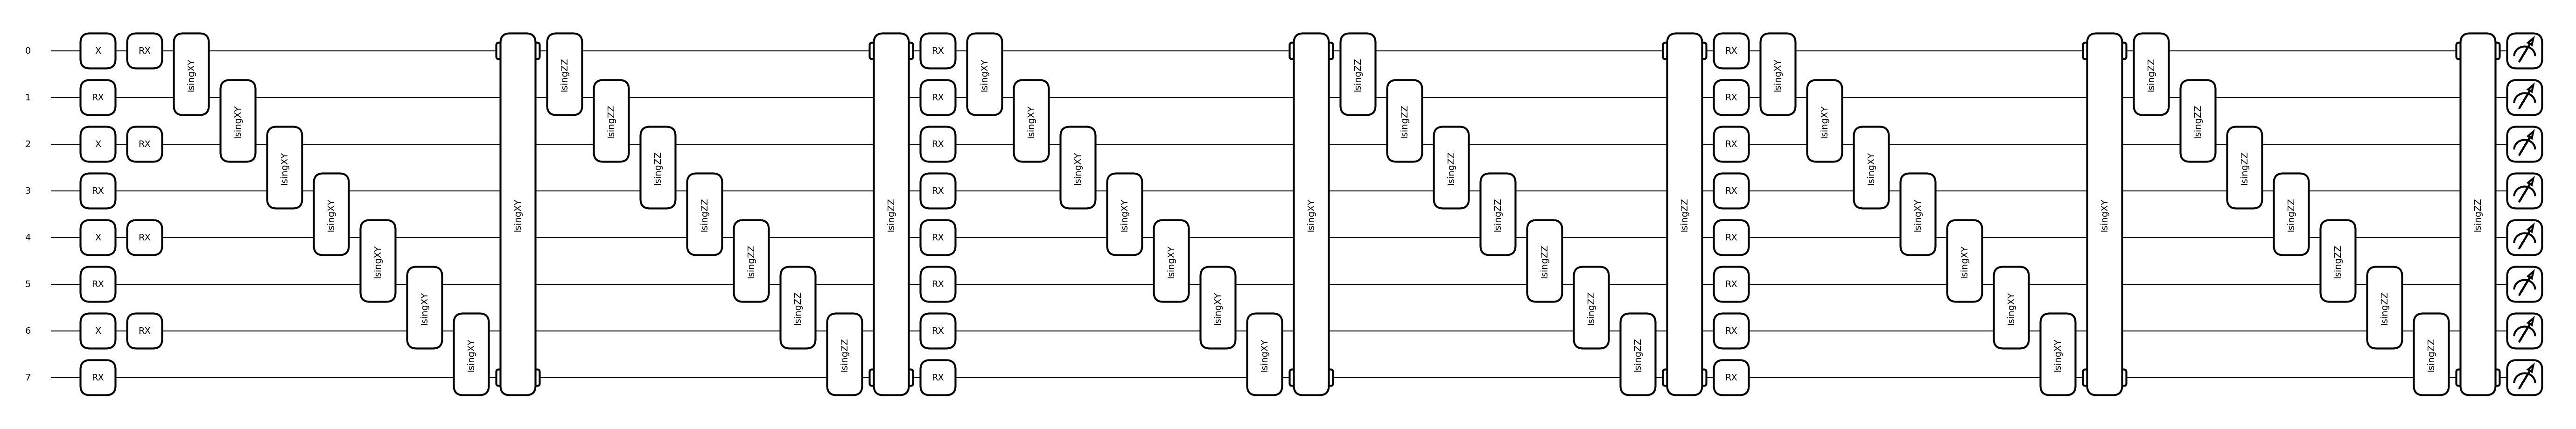

In [26]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [31]:
tr_distance = TraceDistanceLoss()
qcbm = QCBM(circuit,tr_distance,target_dm)

weights = initial_params#.flatten()
# lr = 1
opt = AdamOptimizer(stepsize=0.01)
# opt = GradientDescentOptimizer(stepsize=0.1)
# opt_state = opt.init(weights)

loss = []
parameters = []
n_epochs = 2500
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    loss_val = qcbm.qcbm_loss(weights)
    weights = opt.step(qcbm.qcbm_loss,weights)
    # grad = grad(qcbm.qcbm_loss)()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")

    loss.append(loss_val)
    parameters.append(weights)


Step: 10 Loss: 0.4201883977140737 Time taken per iter: 0.022082090377807617
Step: 20 Loss: 0.36096576846651024 Time taken per iter: 0.023929119110107422
Step: 30 Loss: 0.31114924174383923 Time taken per iter: 0.022058963775634766
Step: 40 Loss: 0.27169564793578627 Time taken per iter: 0.022385120391845703
Step: 50 Loss: 0.23934618129867719 Time taken per iter: 0.02282094955444336
Step: 60 Loss: 0.2128986755283331 Time taken per iter: 0.022409915924072266
Step: 70 Loss: 0.1801992734562458 Time taken per iter: 0.02210688591003418
Step: 80 Loss: 0.16025854382497384 Time taken per iter: 0.023328065872192383
Step: 90 Loss: 0.15255134545962112 Time taken per iter: 0.07418394088745117
Step: 100 Loss: 0.1526471895694925 Time taken per iter: 0.023329734802246094
Step: 110 Loss: 0.15028751942826804 Time taken per iter: 0.022376060485839844
Step: 120 Loss: 0.14779291991244095 Time taken per iter: 0.022055864334106445
Step: 130 Loss: 0.14550282147492083 Time taken per iter: 0.07488179206848145
Ste

Text(0, 0.5, 'Trace distance Loss')

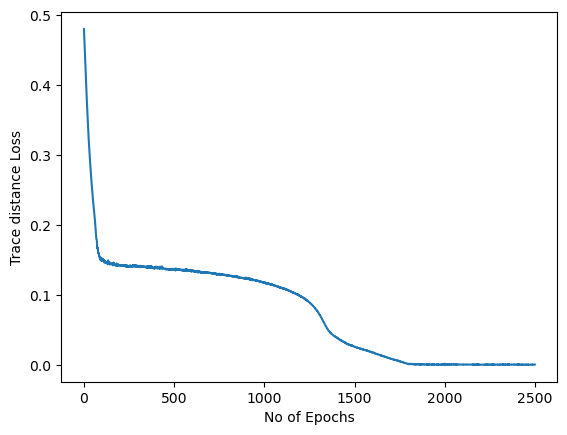

In [32]:
plt.plot(loss)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")

In [33]:
min_loss = loss[np.argmin(loss)]
# optimal_params = parameters[np.argmin(loss)]
# trained_qcbm = circuit(optimal_params)

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 0.0006275926857360151
